# Lab 6 Convolutional Network Architectures


In this lab, you will select a prediction task to perform on your dataset, evaluate a deep learning architecture and tune hyper-parameters. If any part of the assignment is not clear, ask the instructor to clarify.

This report is worth 10% of the final grade. Please upload a report (one per team) with all code used, visualizations, and text in a rendered Jupyter notebook. Any visualizations that cannot be embedded in the notebook, please provide screenshots of the output. The results should be reproducible using your report. Please carefully describe every assumption and every step in your report.

Dataset Selection

Select a dataset identically to lab two (images). That is, the dataset must be image data. In terms of generalization performance, it is helpful to have a large dataset of identically sized images. It is fine to perform binary classification or multi-class classification. You are not allowed to use MNIST, Fashion, MNIST, or the sklearn digits dataset.

# Dataset Description
Dataset: Natural Images

Description: A dataset of 8 different classes with 6899 images. Each class has its own folder.


url: https://www.kaggle.com/datasets/prasunroy/natural-images

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 39.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.2.1 which is incompatible.


In [4]:
!nvidia-smi

Thu Apr 18 17:23:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   34C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Preparation
Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

Search engines would be really interested in our algorithm because it would allow them to have a classifier that tells them whether a provided image falls under one of the 8 categories. The best judge of the efficiency of our algorithm is whether it can accurately predict the data's classes correctly or not, therefore an algorithm that predicts the correct label 80% of the time is always better than on that does it 70% of the time. This is one of those rare cases where "accuracy" is a good performance metric for our purposes

Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice.
Modeling (6 points total)

We know that each folder has roughly the same number of images, so the distribution among the classes is relatively even. Since our data is nearly balanced, we should use StratifiedShuffleSplit. We will be splitting our data 80/20 as well since our dataset has 6899 images, a 20% split will be rouhgly 1380 images, which is sufficient for our needs.

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
print(sss)

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None)


In [6]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import glob

# Define class labels and the dimensions for images
class_labels = {'airplane': 0, 'car': 1, 'cat': 2, 'dog': 3, 'flower': 4, 'fruit': 5, 'motorbike': 6, 'person': 7}
NUM_CLASSES = 8  # Number of categories
img_wh = 150  # width and height of the image

X = []
y = []

# Function to read data and split into training and testing sets
def readDataSplitAndGetLabel(image_paths_with_labels, test_size=0.2):
    data = []
    labels = []

    # Iterate over the paths and corresponding labels
    for path_pattern, label in image_paths_with_labels:
        for img_path in glob.glob(path_pattern):
            image = cv2.imread(img_path)
            if image is not None:
                image = cv2.resize(image, (img_wh, img_wh))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image = image.flatten()
                data.append(image)
                labels.append(class_labels[label])

    # Convert lists to numpy arrays
    data = np.array(data)
    labels = np.array(labels)

    # Shuffle and split the dataset into training and testing
    return train_test_split(data, labels, test_size=test_size, random_state=0)

# List of paths with their corresponding labels
image_paths_with_labels = [
    ('/content/drive/MyDrive/Lab6/airplane/*', 'airplane'),
    ('/content/drive/MyDrive/Lab6/car/*', 'car'),
    ('/content/drive/MyDrive/Lab6/cat/*', 'cat'),
    ('/content/drive/MyDrive/Lab6/dog/*', 'dog'),
    ('/content/drive/MyDrive/Lab6/flower/*', 'flower'),
    ('/content/drive/MyDrive/Lab6/fruit/*', 'fruit'),
    ('/content/drive/MyDrive/Lab6/motorbike/*', 'motorbike'),
    ('/content/drive/MyDrive/Lab6/person/*', 'person')
]

# Get the training and testing data and labels
X_train, X_test, y_train, y_test = readDataSplitAndGetLabel(image_paths_with_labels, test_size=0.2)

# Output dataset details
print("The shape of the training set:", X_train.shape)
print("The shape of the testing set:", X_test.shape)


The shape of the training set: (5519, 22500)
The shape of the testing set: (1380, 22500)


In [7]:
print(X_train)

[[255 255 255 ... 255 255 255]
 [ 55  61  86 ...  80  91  94]
 [122 122 123 ... 254 254 254]
 ...
 [226 229 233 ... 142 141 139]
 [142 142 144 ... 162 158 128]
 [119 135  68 ...  88  87  87]]


In [8]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import average
from tensorflow.keras.models import  Model
from sklearn import metrics as mt
from skimage.io import imshow
import struct
import seaborn as sns
%matplotlib inline

In [9]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
import seaborn as sns
%matplotlib inline

In [10]:
labels = ['airplane','car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels,yticklabels=labels)
    plt.title(title_text+'{:.4f}'.format(acc))

In [11]:
"""Visualizing some data instances we have"""
# function to return key for any value
def get_key(val):
    for key, value in class_labels.items():
        if val == value:
            return key

# a helper plotting function
def plot_gallery(images, titles, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(3 * n_col, 3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((img_wh,img_wh,1)))
        plt.title(get_key(titles[i]), size=16)
        plt.xticks(())
        plt.yticks(())

Some of the training data:


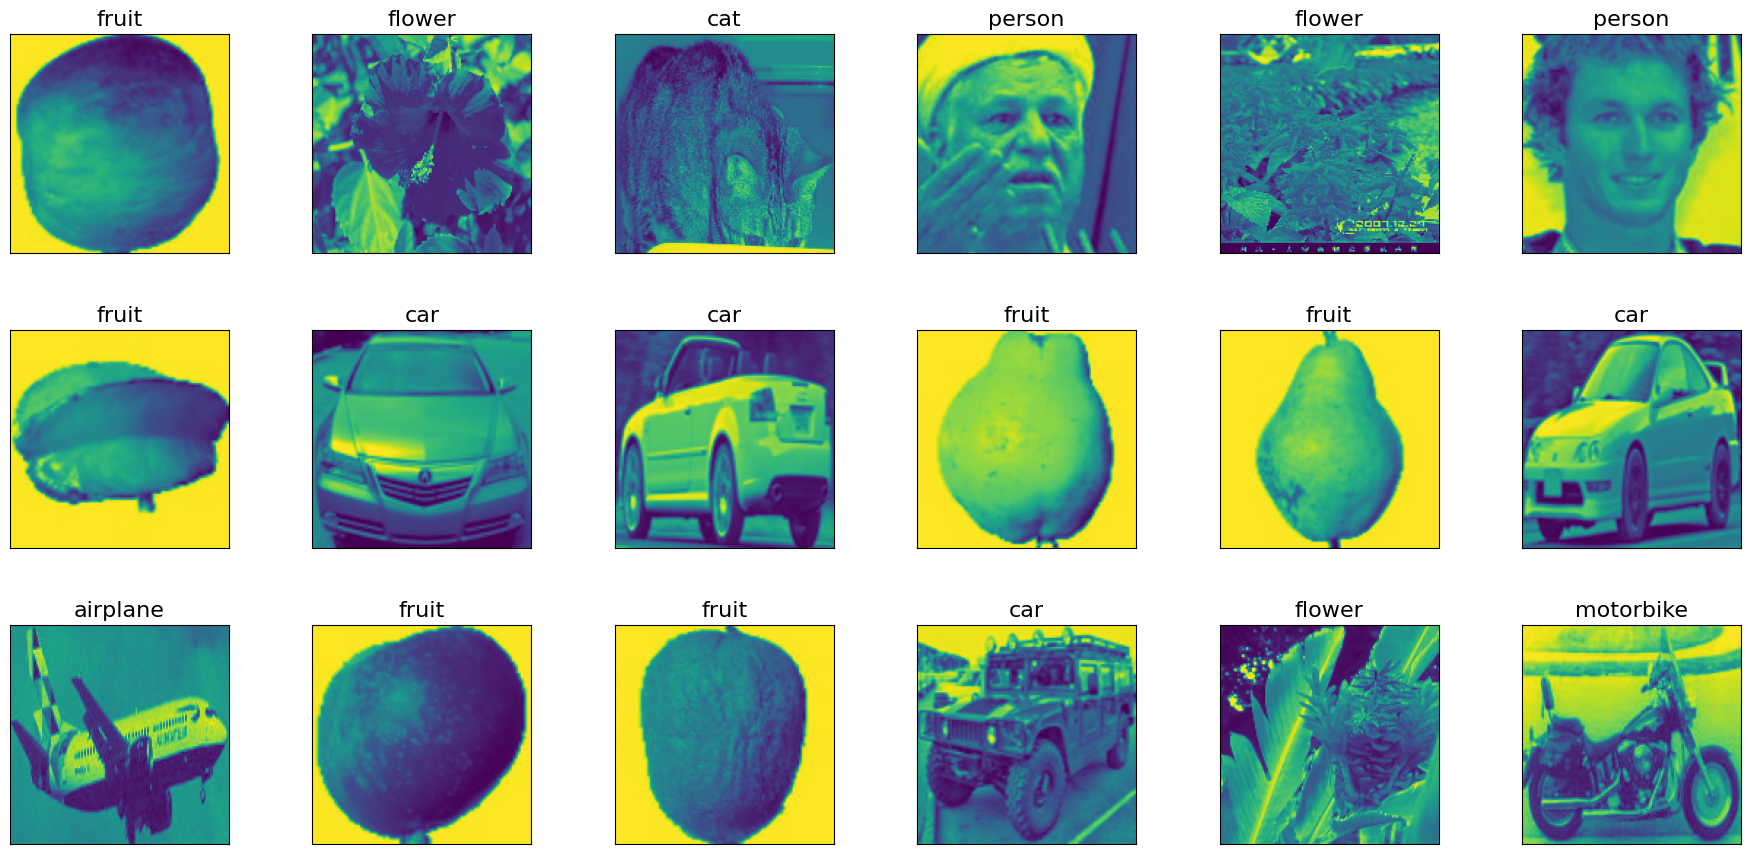

In [12]:
#Display training data
print("Some of the training data:")
plot_gallery(X_train, y_train)

Some of the testing data:


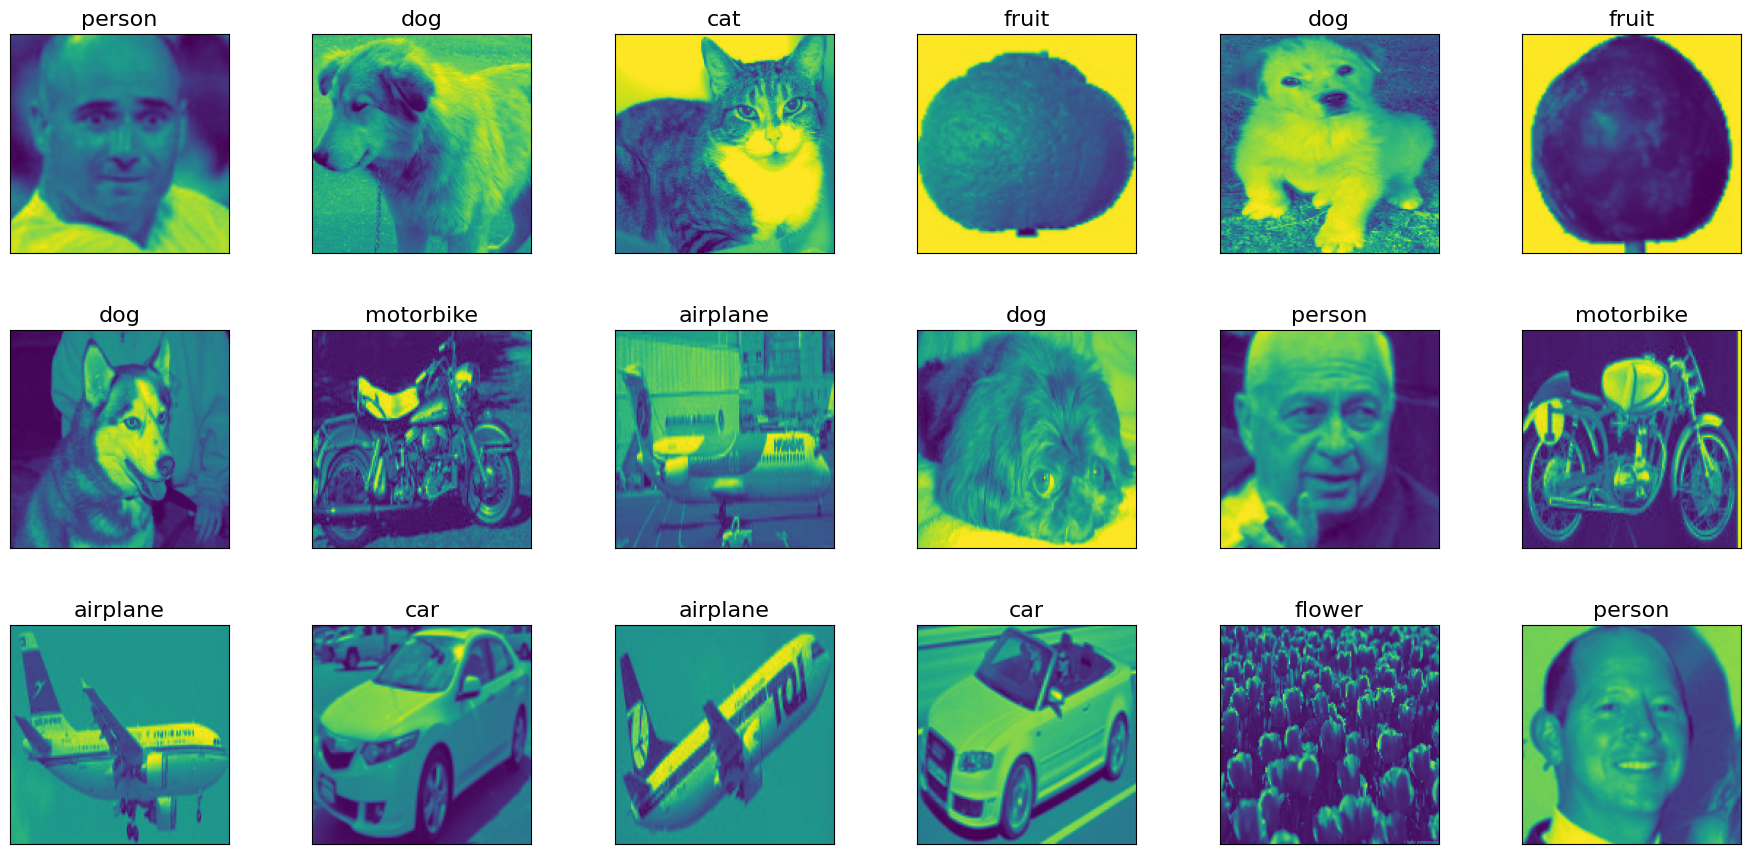

In [13]:
print("Some of the testing data:")
plot_gallery(X_test, y_test)

In [14]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([584, 792, 699, 563, 667, 800, 623, 791]))

In [69]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([143, 176, 186, 139, 176, 200, 165, 195]))

In [16]:
X_train = np.expand_dims(X_train.reshape((-1,img_wh,img_wh)), axis=3)
X_test = np.expand_dims(X_test.reshape((-1,img_wh,img_wh)), axis=3)
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [17]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5519, 150, 150, 1)
(5519,)
(1380, 150, 150, 1)
(1380,)


# Modeling

Setup the training to use data expansion in Keras (also called data augmentation). Explain why the chosen data expansion techniques are appropriate for your dataset. You should make use of Keras augmentation layers, like in the class examples.

We implement data expansion through Keras's ImageDataGenerator as seen in the instructor code. We utilized a 10% width and height shift in our images along with a 5º rotational transform. These parameters we copied from the instructor code  because we saw see no reason to modify them for our dataset and images. These mutations allow for change in the images without losing the integrity of the class. Any shift or rotation larger than these thresholds threaten losing essential information in the images.

In [18]:
datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None)

datagen.fit(X_train)

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


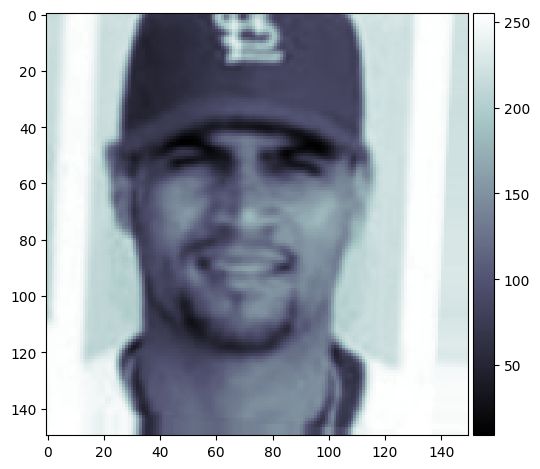

In [70]:
img_datagem = datagen.flow(X_train, y_train_ohe, batch_size=1)

for tmp in img_datagem:
    imshow(tmp[0].squeeze(),cmap='bone')
    break

First Convolutional Network - 32 Filters, Kernal Size of 4

In [19]:
img_wh = 150
cnn = Sequential()


cnn.add(Conv2D(filters=32,
                input_shape = (img_wh,img_wh,1),
                kernel_size=(4,4),
                padding='same',
                activation='relu', data_format="channels_last"))\


cnn.add(Conv2D(filters=32,
                kernel_size=(4,4),
                padding='same',
                activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))


# add one layer on flattened output
cnn.add( Flatten() )
cnn.add( Dense(100) )
cnn.add( Activation('relu') )
cnn.add( Dense(NUM_CLASSES) )
cnn.add( Activation('softmax') )

# Let's train the model
cnn.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

history = cnn.fit(datagen.flow(X_train, y_train_ohe, batch_size=64),
                   steps_per_epoch=int(len(X_train)/64), # how many generators to go through per epoch
                   epochs=30, verbose=1,
                   validation_data=(X_test,y_test_ohe))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


86/86 ━━━━━━━━━━━━━━━━━━━━ 26s 163ms/step - accuracy: 0.2357 - loss: 406.3435 - val_accuracy: 0.4761 - val_loss: 1.5541
Epoch 2/30
 1/86 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.5469 - loss: 1.4818

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5469 - loss: 1.4818 - val_accuracy: 0.4812 - val_loss: 1.5422
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.4532 - loss: 1.5645 - val_accuracy: 0.6616 - val_loss: 1.1105
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5625 - loss: 1.4317 - val_accuracy: 0.6514 - val_loss: 1.1155
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.5368 - loss: 3.4659 - val_accuracy: 0.6993 - val_loss: 0.9997
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6562 - loss: 1.3269 - val_accuracy: 0.7072 - val_loss: 1.0286
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.6800 - loss: 1.0086 - val_accuracy: 0.6167 - val_loss: 1.2423
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6562 - loss: 1.0925 - val_accuracy: 0.5645 - val_loss: 1.5778
Epoch 9/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.6405 - loss: 1.1025 - val_accuracy: 0.7529 - val_loss

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


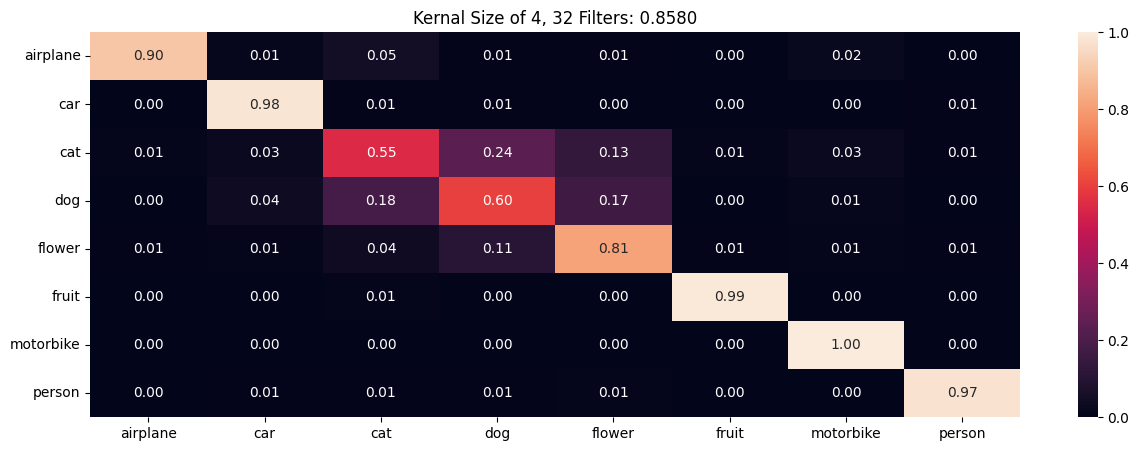

In [20]:
summarize_net(cnn, X_test, y_test, title_text='Kernal Size of 4, 32 Filters: ')

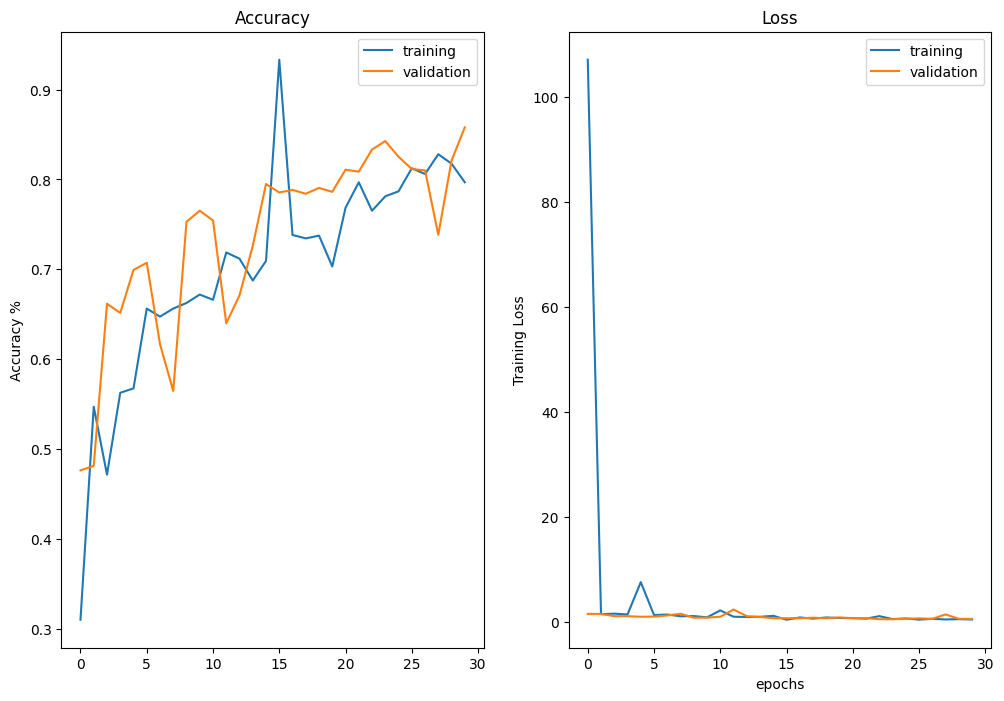

In [67]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='training')

plt.ylabel('Accuracy %')
plt.title('Training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='training')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend()
plt.show()

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from scikeras.wrappers import KerasClassifier

model = KerasClassifier(model=cnn, epochs=30, batch_size=10, verbose=1)
my_scorer = make_scorer(accuracy_score)
results = cross_val_score(model, X_test, y_test_ohe, cv=sss, scoring=my_scorer)
print(results.mean())

Epoch 1/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.8053 - loss: 1.0045
Epoch 2/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9025 - loss: 0.3999
Epoch 3/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9272 - loss: 0.9008
Epoch 4/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9424 - loss: 4.0037
Epoch 5/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9720 - loss: 0.2297
Epoch 6/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9839 - loss: 0.3340
Epoch 7/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9753 - loss: 0.9477
Epoch 8/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9117 - loss: 8.5188
Epoch 9/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9735 - loss: 0.8621
Epoch 10/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9826 - loss: 0.3676
Epoch 11/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9712 - loss: 1.9826
Epoch 12/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/ste

Second Convolutional Network - 32 Filters, Kernal Size of 3

In [23]:
cnn2 = Sequential()


cnn2.add(Conv2D(filters=32,
                input_shape = (img_wh,img_wh,1),
                kernel_size=(3,3),
                padding='same',
                activation='relu', data_format="channels_last"))


cnn2.add(Conv2D(filters=32,
                kernel_size=(3,3),
                padding='same',
                activation='relu'))
cnn2.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))


# add one layer on flattened output
cnn2.add( Flatten() )
cnn2.add( Dense(100) )
cnn2.add( Activation('relu') )
cnn2.add( Dense(NUM_CLASSES) )
cnn2.add( Activation('softmax') )

# Let's train the model
cnn2.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

history2 = cnn2.fit(datagen.flow(X_train, y_train_ohe, batch_size=64),
                   steps_per_epoch=int(len(X_train)/64), # how many generators to go through per epoch
                   epochs=30, verbose=1,
                   validation_data=(X_test,y_test_ohe))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


86/86 ━━━━━━━━━━━━━━━━━━━━ 21s 151ms/step - accuracy: 0.3040 - loss: 261.9955 - val_accuracy: 0.6543 - val_loss: 1.1762
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5938 - loss: 1.0225 - val_accuracy: 0.6862 - val_loss: 1.0988
Epoch 3/30


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.5899 - loss: 1.3204 - val_accuracy: 0.7457 - val_loss: 0.7817
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7656 - loss: 0.7304 - val_accuracy: 0.7623 - val_loss: 0.8332
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.6452 - loss: 1.2592 - val_accuracy: 0.7797 - val_loss: 0.7115
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8438 - loss: 0.7791 - val_accuracy: 0.7855 - val_loss: 0.7571
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.7059 - loss: 1.2017 - val_accuracy: 0.7565 - val_loss: 0.8632
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7188 - loss: 0.8048 - val_accuracy: 0.7848 - val_loss: 0.7077
Epoch 9/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - accuracy: 0.7134 - loss: 0.9174 - val_accuracy: 0.7449 - val_loss: 1.0463
Epoch 10/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7031 - loss: 0.8303 - val_accuracy: 0.8152 - val_loss

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


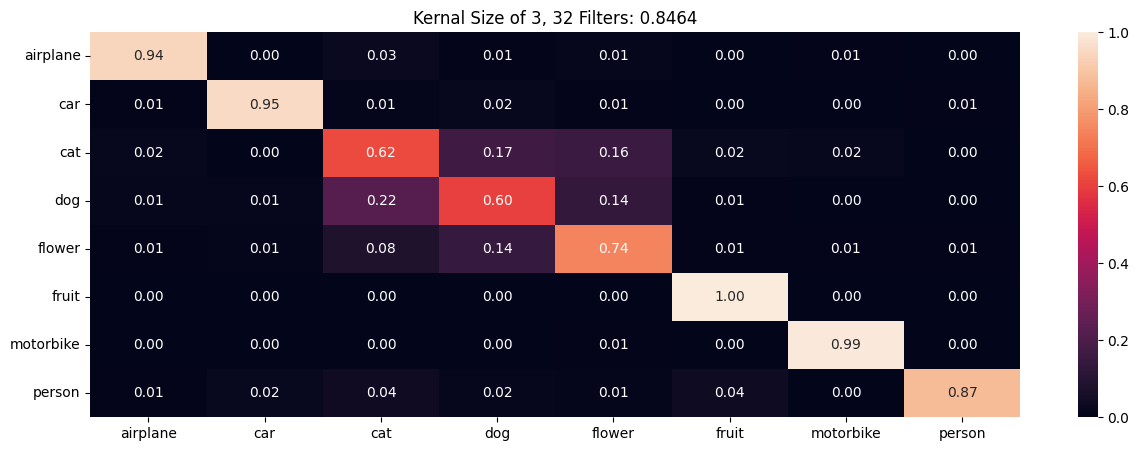

In [24]:
summarize_net(cnn2, X_test, y_test, title_text='Kernal Size of 3, 32 Filters: ')

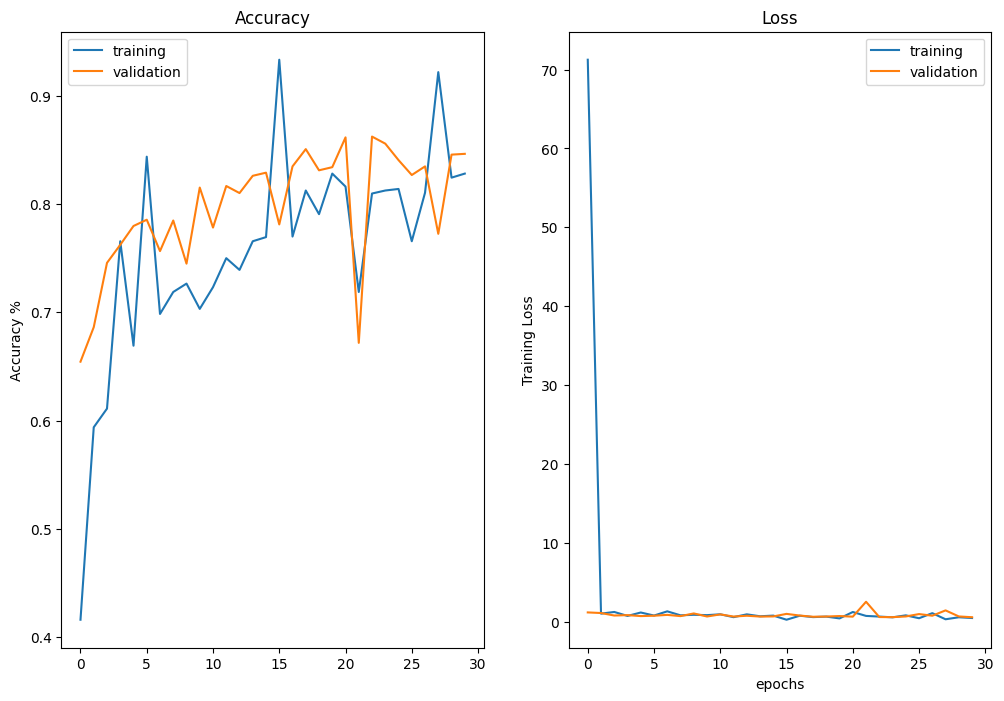

In [66]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(history2.history['accuracy'], label='training')

plt.ylabel('Accuracy %')
plt.title('Training')
plt.plot(history2.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history2.history['loss'], label='training')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.plot(history2.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend()
plt.show()

In [26]:
model2 = KerasClassifier(model=cnn2, epochs=30, batch_size=10, verbose=1)
my_scorer2 = make_scorer(accuracy_score)
results2 = cross_val_score(model2, X_test, y_test_ohe, cv=sss, scoring=my_scorer2)
print(results2.mean())

Epoch 1/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7698 - loss: 3.9826
Epoch 2/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8933 - loss: 0.4682
Epoch 3/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9555 - loss: 0.3477
Epoch 4/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9782 - loss: 0.1143
Epoch 5/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9709 - loss: 1.1052
Epoch 6/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9798 - loss: 0.2756
Epoch 7/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9872 - loss: 0.3366
Epoch 8/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9743 - loss: 0.5202
Epoch 9/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9719 - loss: 0.3044
Epoch 10/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9880 - loss: 0.0916
Epoch 11/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9770 - loss: 7.7677
Epoch 12/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/ste

Third Convolutional Network - 16 Filters, Kernal Size of 4

In [27]:
cnn3 = Sequential()


cnn3.add(Conv2D(filters=16,
                input_shape = (img_wh,img_wh,1),
                kernel_size=(4,4),
                padding='same',
                activation='relu', data_format="channels_last"))\


cnn3.add(Conv2D(filters=16,
                kernel_size=(4,4),
                padding='same',
                activation='relu'))
cnn3.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))


# add one layer on flattened output
cnn3.add( Flatten() )
cnn3.add( Dense(100) )
cnn3.add( Activation('relu') )
cnn3.add( Dense(NUM_CLASSES) )
cnn3.add( Activation('softmax') )

# Let's train the model
cnn3.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

history3 = cnn3.fit(datagen.flow(X_train, y_train_ohe, batch_size=64),
                   steps_per_epoch=int(len(X_train)/64), # how many generators to go through per epoch
                   epochs=30, verbose=1,
                   validation_data=(X_test,y_test_ohe))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


86/86 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.3316 - loss: 624.5359 - val_accuracy: 0.6732 - val_loss: 1.0497
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5625 - loss: 1.2411 - val_accuracy: 0.6565 - val_loss: 1.0609
Epoch 3/30


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.5741 - loss: 1.4305 - val_accuracy: 0.7268 - val_loss: 0.9298
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6094 - loss: 1.0175 - val_accuracy: 0.7304 - val_loss: 0.9727
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.6246 - loss: 1.4320 - val_accuracy: 0.6601 - val_loss: 1.3054
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6094 - loss: 1.0668 - val_accuracy: 0.6739 - val_loss: 1.2148
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.6893 - loss: 0.9738 - val_accuracy: 0.7435 - val_loss: 0.8265
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6719 - loss: 1.0208 - val_accuracy: 0.7435 - val_loss: 0.7865
Epoch 9/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.6670 - loss: 1.0834 - val_accuracy: 0.7507 - val_loss: 0.9520
Epoch 10/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7344 - loss: 0.7740 - val_accuracy: 0.7674 - val_loss: 0.8

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


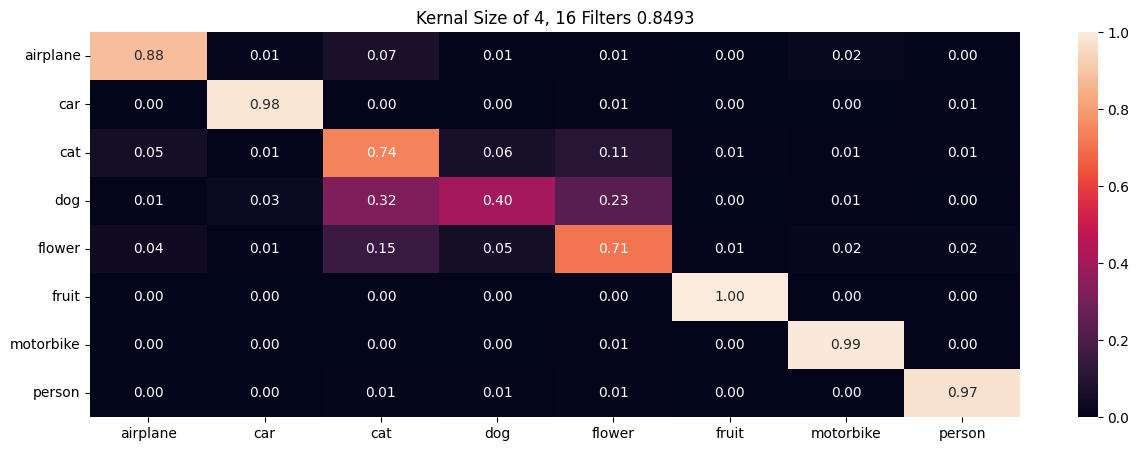

In [28]:
summarize_net(cnn3, X_test, y_test, title_text='Kernal Size of 4, 16 Filters ')

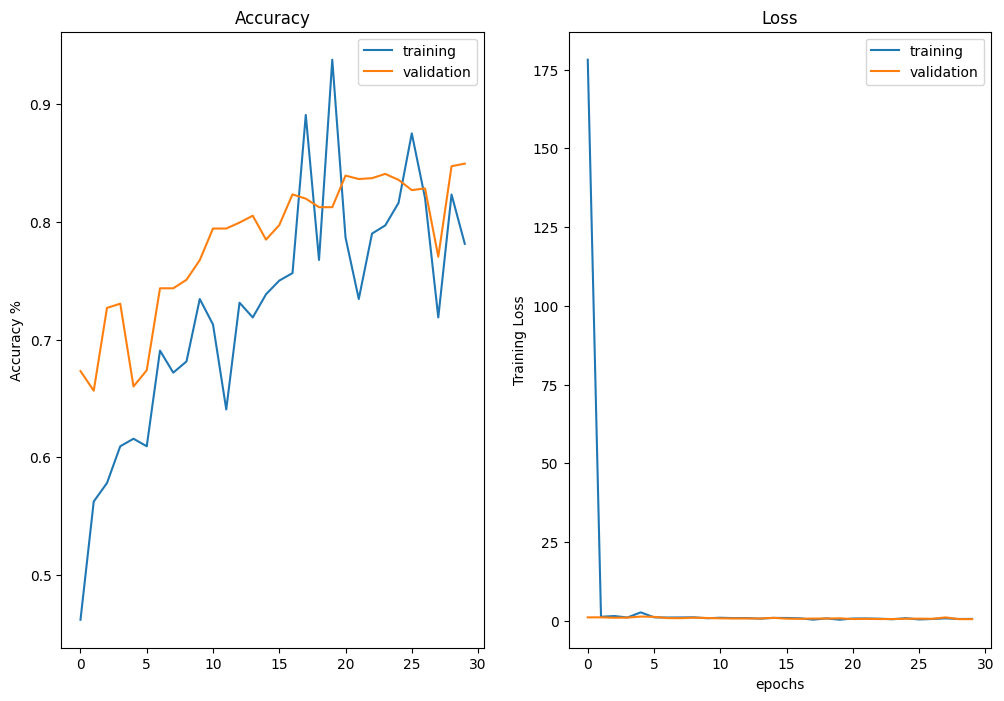

In [65]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(history3.history['accuracy'], label='training')

plt.ylabel('Accuracy %')
plt.title('Training')
plt.plot(history3.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history3.history['loss'], label='training')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.plot(history3.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend()
plt.show()

In [30]:
model3 = KerasClassifier(model=cnn3, epochs=30, batch_size=10, verbose=1)
my_scorer3 = make_scorer(accuracy_score)
results3 = cross_val_score(model3, X_test, y_test_ohe, cv=sss, scoring=my_scorer3)
print(results3.mean())

Epoch 1/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8229 - loss: 0.6870
Epoch 2/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9391 - loss: 0.2130
Epoch 3/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9678 - loss: 0.1634
Epoch 4/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9804 - loss: 0.0890
Epoch 5/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9749 - loss: 0.5708
Epoch 6/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9821 - loss: 0.1774
Epoch 7/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9543 - loss: 7.0255
Epoch 8/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9797 - loss: 0.2153
Epoch 9/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9412 - loss: 3.2218
Epoch 10/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9545 - loss: 5.2299
Epoch 11/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9875 - loss: 0.5013
Epoch 12/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste

Fourth Convolutional Network - 16 Filters, Kernal Size of 3

In [31]:
cnn4 = Sequential()


cnn4.add(Conv2D(filters=16,
                input_shape = (img_wh,img_wh,1),
                kernel_size=(3,3),
                padding='same',
                activation='relu', data_format="channels_last"))\


cnn4.add(Conv2D(filters=16,
                kernel_size=(3,3),
                padding='same',
                activation='relu'))
cnn4.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))


# add one layer on flattened output
cnn4.add( Flatten() )
cnn4.add( Dense(100) )
cnn4.add( Activation('relu') )
cnn4.add( Dense(NUM_CLASSES) )
cnn4.add( Activation('softmax') )

# Let's train the model
cnn4.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

history4 = cnn4.fit(datagen.flow(X_train, y_train_ohe, batch_size=64),
                   steps_per_epoch=int(len(X_train)/64), # how many generators to go through per epoch
                   epochs=30, verbose=1,
                   validation_data=(X_test,y_test_ohe))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


86/86 ━━━━━━━━━━━━━━━━━━━━ 17s 132ms/step - accuracy: 0.3196 - loss: 470.1438 - val_accuracy: 0.5891 - val_loss: 1.4941
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4219 - loss: 1.6463 - val_accuracy: 0.6225 - val_loss: 1.1970
Epoch 3/30


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.5556 - loss: 1.3682 - val_accuracy: 0.5246 - val_loss: 1.8840
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5625 - loss: 1.2521 - val_accuracy: 0.6101 - val_loss: 1.3068
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.5862 - loss: 1.3738 - val_accuracy: 0.7362 - val_loss: 0.8486
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7344 - loss: 0.9866 - val_accuracy: 0.6732 - val_loss: 1.1164
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.6506 - loss: 1.0626 - val_accuracy: 0.7225 - val_loss: 1.0480
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7031 - loss: 1.0107 - val_accuracy: 0.6116 - val_loss: 1.5345
Epoch 9/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.6863 - loss: 0.9708 - val_accuracy: 0.7580 - val_loss: 0.9131
Epoch 10/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7031 - loss: 0.7481 - val_accuracy: 0.7754 - val_loss: 0.7

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


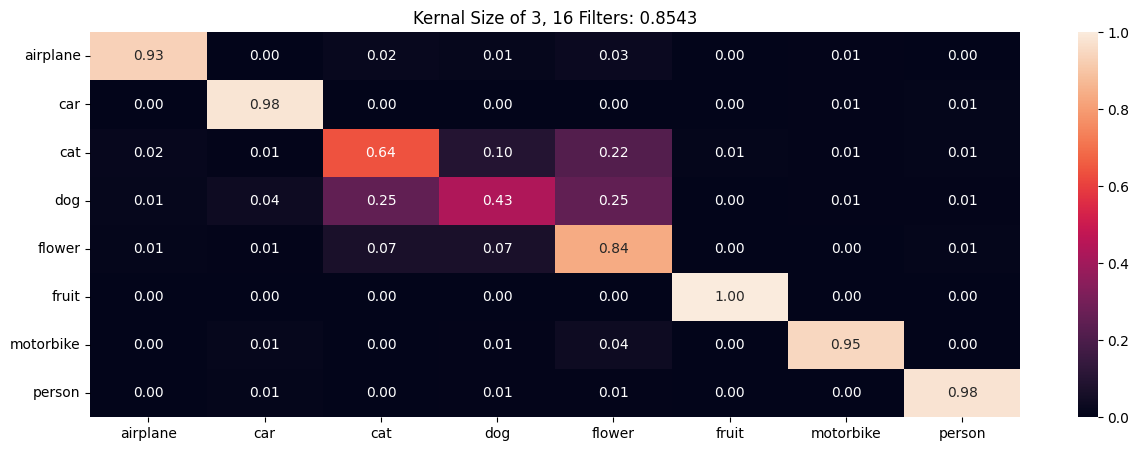

In [32]:
summarize_net(cnn4, X_test, y_test, title_text='Kernal Size of 3, 16 Filters: ')

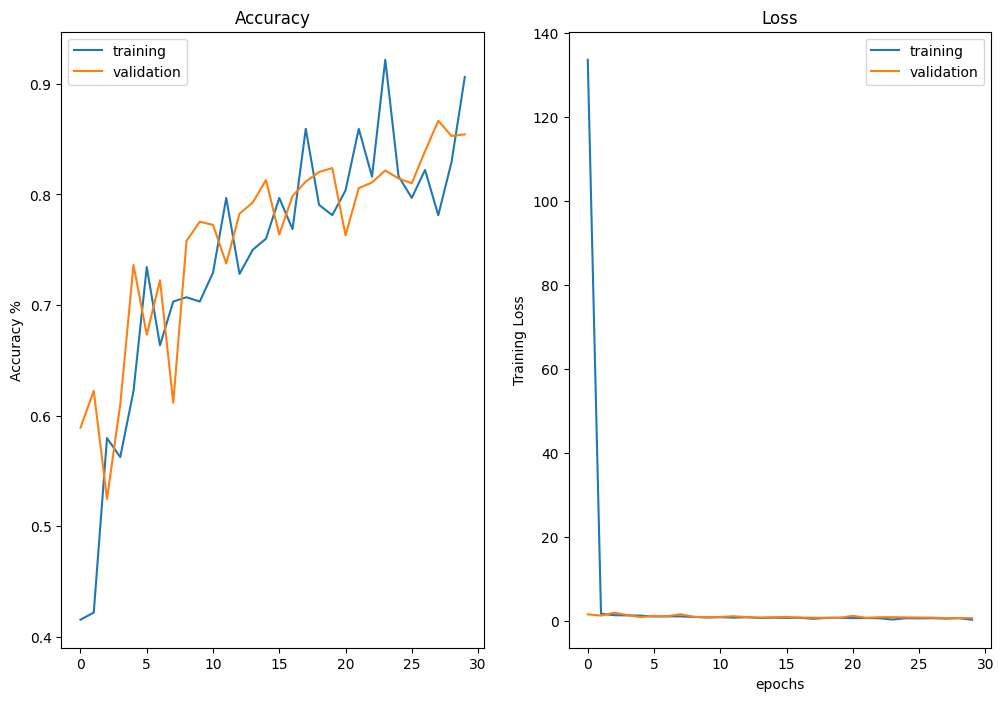

In [64]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(history4.history['accuracy'], label='training')

plt.ylabel('Accuracy %')
plt.title('Training')
plt.plot(history4.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history4.history['loss'], label='training')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.plot(history4.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend()
plt.show()

In [34]:
model4 = KerasClassifier(model=cnn4, epochs=30, batch_size=10, verbose=1)
my_scorer4 = make_scorer(accuracy_score)
results4 = cross_val_score(model4, X_test, y_test_ohe, cv=sss, scoring=my_scorer4)
print(results4.mean())

Epoch 1/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8175 - loss: 0.9003
Epoch 2/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9320 - loss: 0.2066
Epoch 3/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9777 - loss: 0.0599
Epoch 4/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9717 - loss: 0.2170
Epoch 5/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9808 - loss: 0.1214
Epoch 6/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9782 - loss: 0.7115
Epoch 7/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9685 - loss: 0.4211
Epoch 8/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9808 - loss: 0.7010
Epoch 9/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9837 - loss: 0.2453
Epoch 10/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9983 - loss: 0.0093
Epoch 11/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9716 - loss: 1.1118
Epoch 12/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste

Visualize the final results of all the CNNs and interpret/compare the performances. Use proper statistics as appropriate, especially for comparing models.

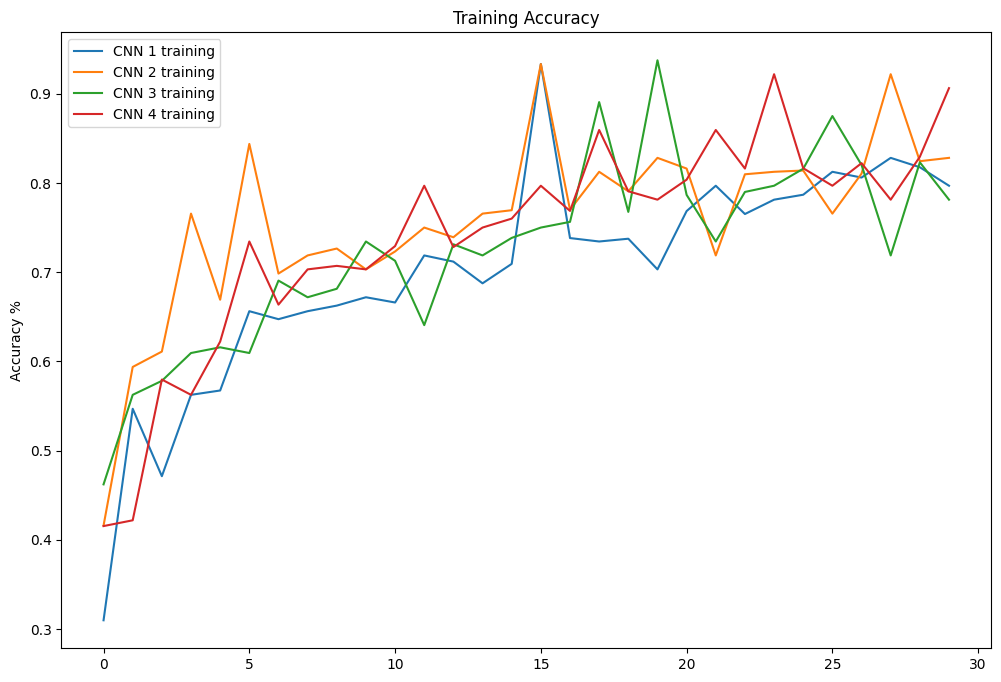

In [63]:
plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'], label='CNN 1 training')
plt.plot(history2.history['accuracy'], label='CNN 2 training')
plt.plot(history3.history['accuracy'], label='CNN 3 training')
plt.plot(history4.history['accuracy'], label='CNN 4 training')
plt.ylabel('Accuracy %')
plt.title('Training')
plt.title('Training Accuracy')
plt.legend()
plt.show()

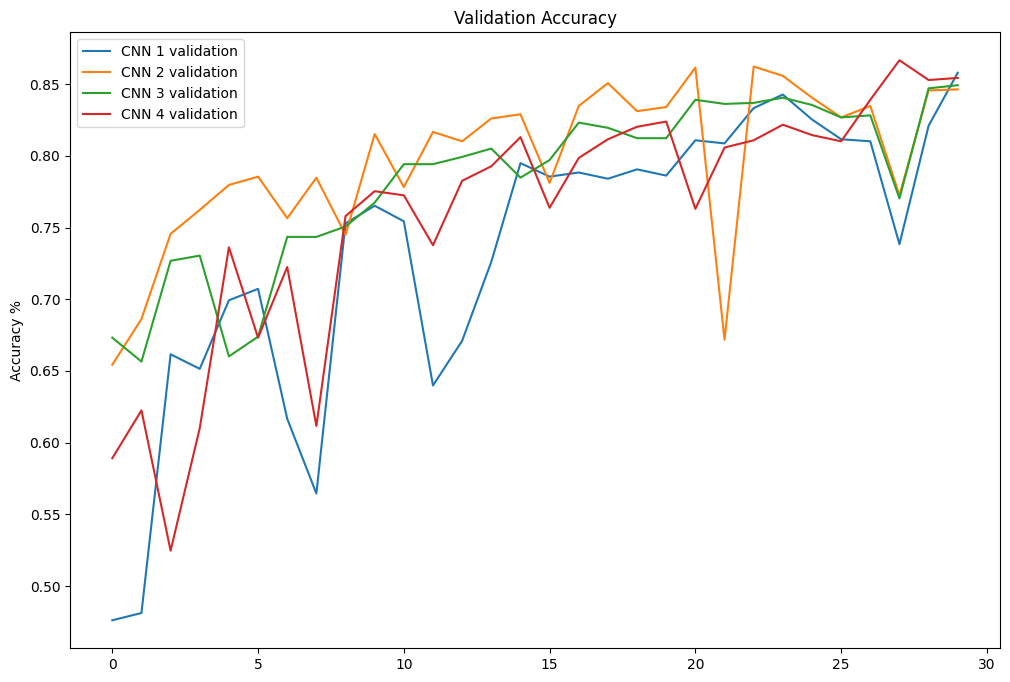

In [62]:
plt.figure(figsize=(12,8))
plt.plot(history.history['val_accuracy'], label='CNN 1 validation')
plt.plot(history2.history['val_accuracy'], label='CNN 2 validation')
plt.plot(history3.history['val_accuracy'], label='CNN 3 validation')
plt.plot(history4.history['val_accuracy'], label='CNN 4 validation')
plt.ylabel('Accuracy %')
plt.title('Training')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Training Loss')

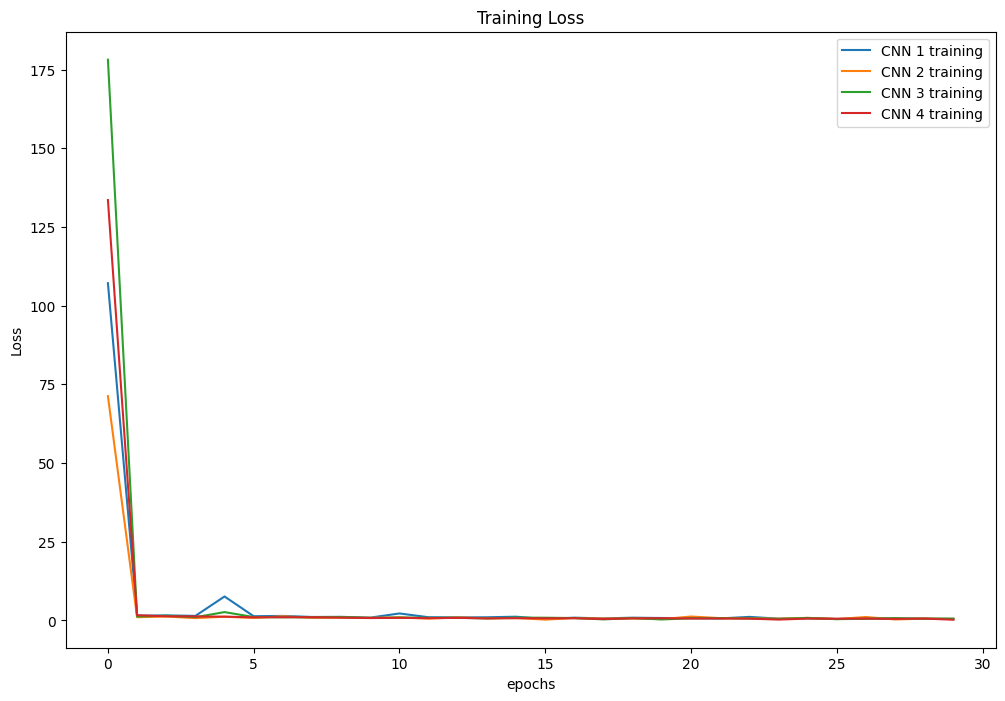

In [61]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='CNN 1 training')
plt.plot(history2.history['loss'], label='CNN 2 training')
plt.plot(history3.history['loss'], label='CNN 3 training')
plt.plot(history4.history['loss'], label='CNN 4 training')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()
plt.title('Training Loss')

Limiting the Y-Axis to better see differences in training loss

Text(0.5, 1.0, 'Training Loss')

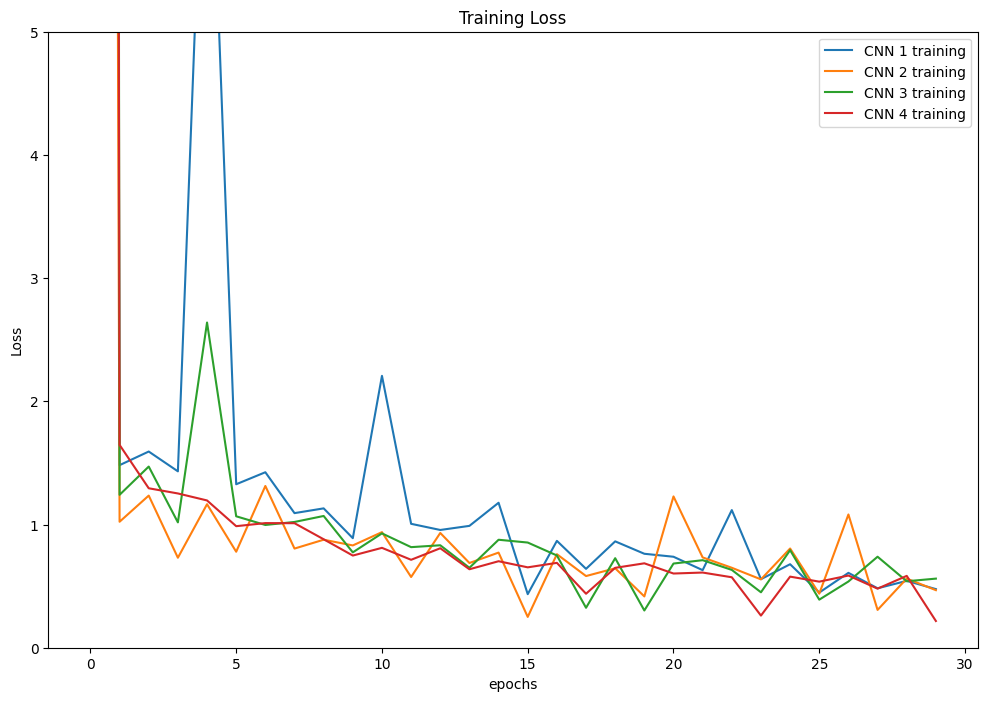

In [72]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='CNN 1 training')
plt.plot(history2.history['loss'], label='CNN 2 training')
plt.plot(history3.history['loss'], label='CNN 3 training')
plt.plot(history4.history['loss'], label='CNN 4 training')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.ylim(0, 5)
plt.legend()
plt.title('Training Loss')

Text(0.5, 1.0, 'Validation Loss')

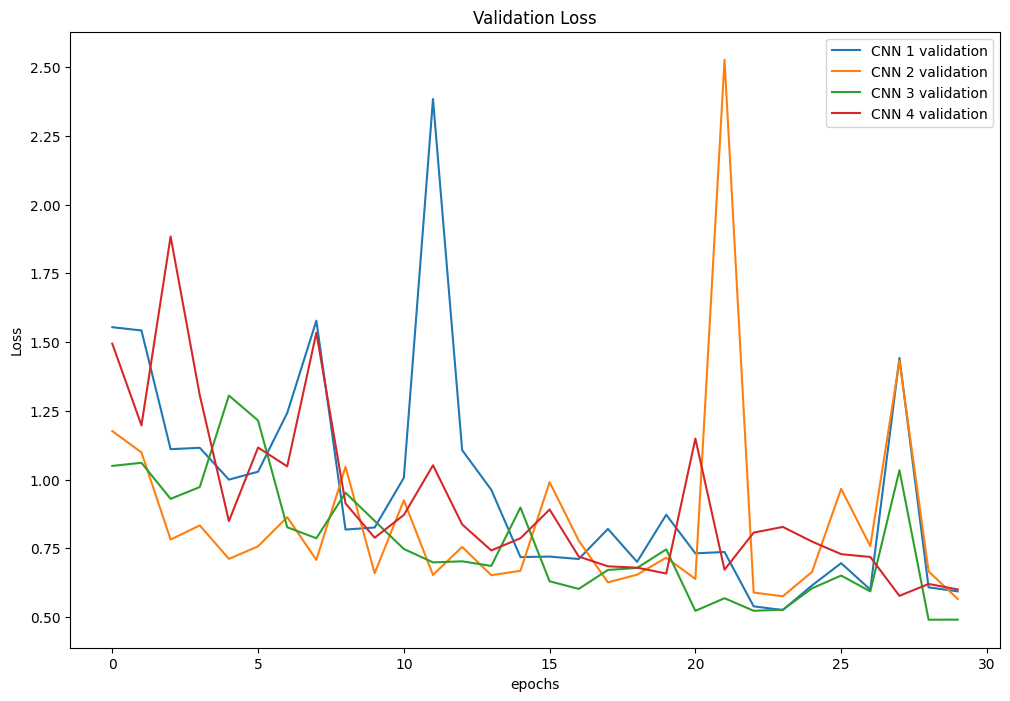

In [60]:
plt.figure(figsize=(12,8))
plt.plot(history.history['val_loss'], label='CNN 1 validation')
plt.plot(history2.history['val_loss'], label='CNN 2 validation')
plt.plot(history3.history['val_loss'], label='CNN 3 validation')
plt.plot(history4.history['val_loss'], label='CNN 4 validation')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()
plt.title('Validation Loss')

In [39]:
print("CNN 1 average accuracy: ", results.mean())
print("CNN 2 average accuracy: ", results2.mean())
print("CNN 3 average accuracy: ", results3.mean())
print("CNN 4 average accuracy: ", results4.mean())

CNN 1 average accuracy:  0.8137681159420289
CNN 2 average accuracy:  0.8304347826086955
CNN 3 average accuracy:  0.8115942028985508
CNN 4 average accuracy:  0.8333333333333334


Model 4 appears to have the best performance out of all 4 models, with an an average accuracy of 0.833. Model 2 had the second best performance at 0.830, Model 1 had the third best performance at 0.813, and Model 3 had the worst performance at 0.811. It appears that using a kernal size of 3 yields better performance than a kernal size of 4, while changing the filters did not change performance much.

While Model 4 and Model 2 have extremely similar accuracy scores, we ultimately decided that Model 4 is the best performing model because Model 4 had lower validation and training loss compared to Model 2

Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.  

We will be comparing CNN Model 4, as we determined that Model 4 is our best performing model

In [40]:
# make a keras MLP
mlp = Sequential()
mlp.add( Flatten() )
mlp.add( Dense(input_dim=X_train.shape[1], units=100, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history_mlp = mlp.fit(datagen.flow(X_train, y_train_ohe, batch_size=64),
                   steps_per_epoch=int(len(X_train)/64), # how many generators to go through per epoch
                   epochs=30, verbose=1,
                   validation_data=(X_test,y_test_ohe))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


86/86 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - accuracy: 0.1579 - loss: 1631.8990 - val_accuracy: 0.2507 - val_loss: 198.9210
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2812 - loss: 148.0497 - val_accuracy: 0.1688 - val_loss: 246.5128
Epoch 3/30


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.1935 - loss: 321.6130 - val_accuracy: 0.3109 - val_loss: 104.2525
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3438 - loss: 116.0637 - val_accuracy: 0.3145 - val_loss: 98.1525
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.2289 - loss: 107.2814 - val_accuracy: 0.0935 - val_loss: 91.6203
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1094 - loss: 81.8667 - val_accuracy: 0.0587 - val_loss: 109.0734
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.1795 - loss: 77.9123 - val_accuracy: 0.1906 - val_loss: 66.2340
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1875 - loss: 58.9485 - val_accuracy: 0.1906 - val_loss: 45.6509
Epoch 9/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.2160 - loss: 64.9364 - val_accuracy: 0.1681 - val_loss: 43.0068
Epoch 10/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1875 - loss: 40.4924 - val_accuracy: 0.20

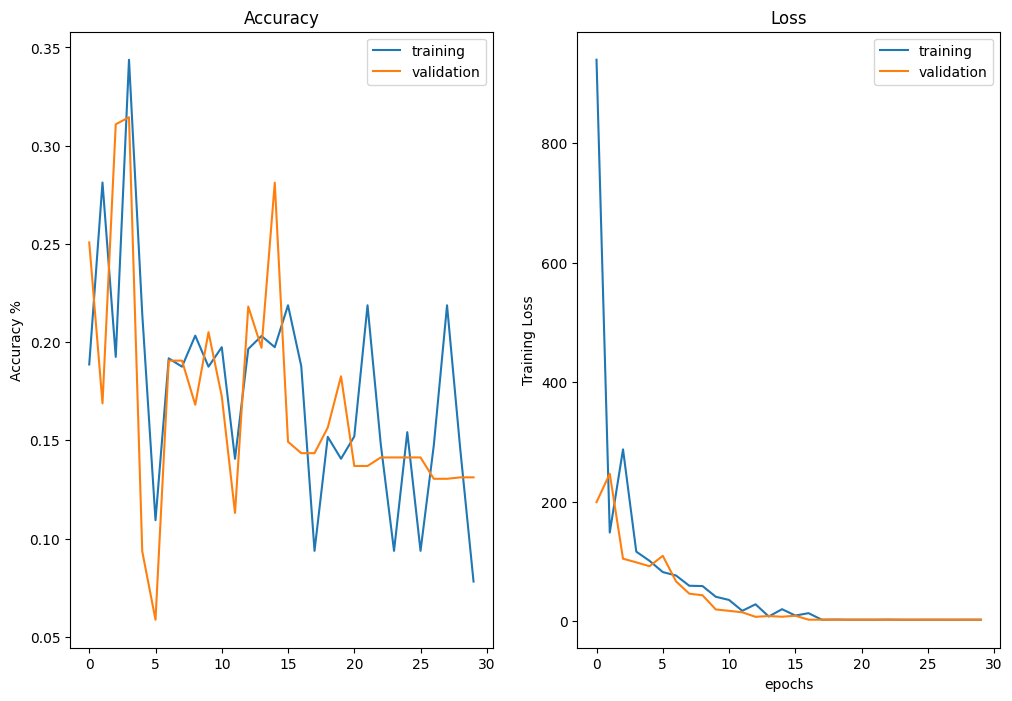

In [59]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(history_mlp.history['accuracy'], label='training')

plt.ylabel('Accuracy %')
plt.title('Training')
plt.plot(history_mlp.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_mlp.history['loss'], label='training')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.plot(history_mlp.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend()
plt.show()

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


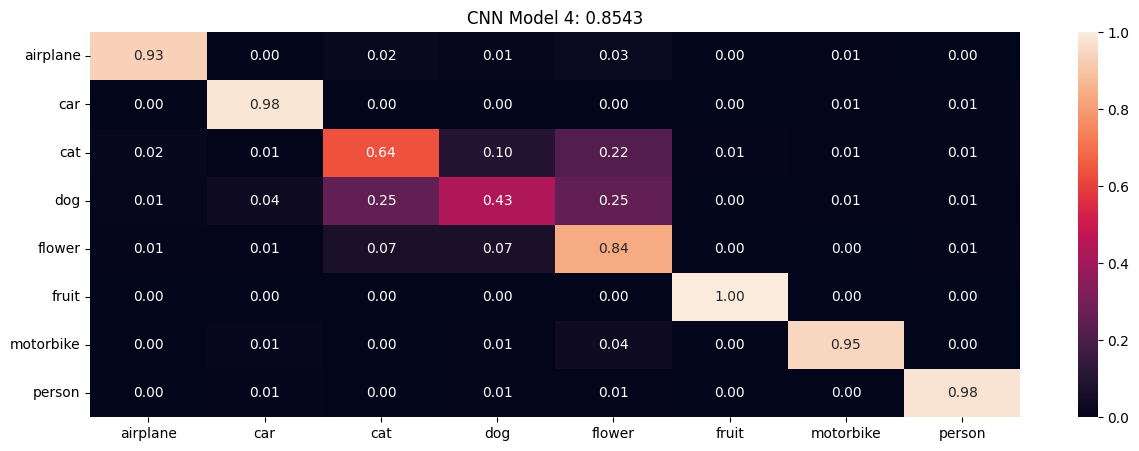

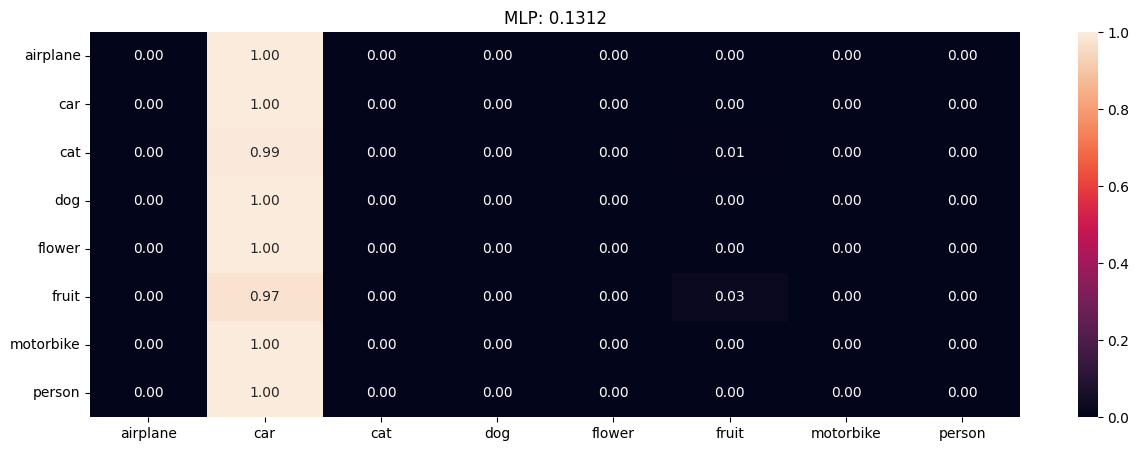

In [73]:
summarize_net(cnn4, X_test, y_test, title_text='CNN Model 4: ')
summarize_net(mlp, X_test, y_test, title_text='MLP: ')

Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.  

In [43]:
from sklearn.metrics import roc_curve, auc, accuracy_score

In [44]:
def network_predict(nn, X_test, y_test):
    """Returns an accuracy for a neural network, a confusion matrix, and ROC data"""
    yhat_proba = nn.predict(X_test)
    yhat = np.round(yhat_proba)
    acc = mt.accuracy_score(y_test, yhat)
    fpr, tpr, _ = roc_curve(y_test.flatten(), yhat_proba.flatten())
    roc_auc = auc(fpr, tpr)
    return acc, fpr, tpr, roc_auc

In [45]:
acc, fpr_mlp, tpr_mlp, roc_auc_mlp = network_predict(mlp, X_test, y_test_ohe)
acc, fpr_cnn, tpr_cnn, roc_auc_cnn = network_predict(cnn4, X_test, y_test_ohe)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


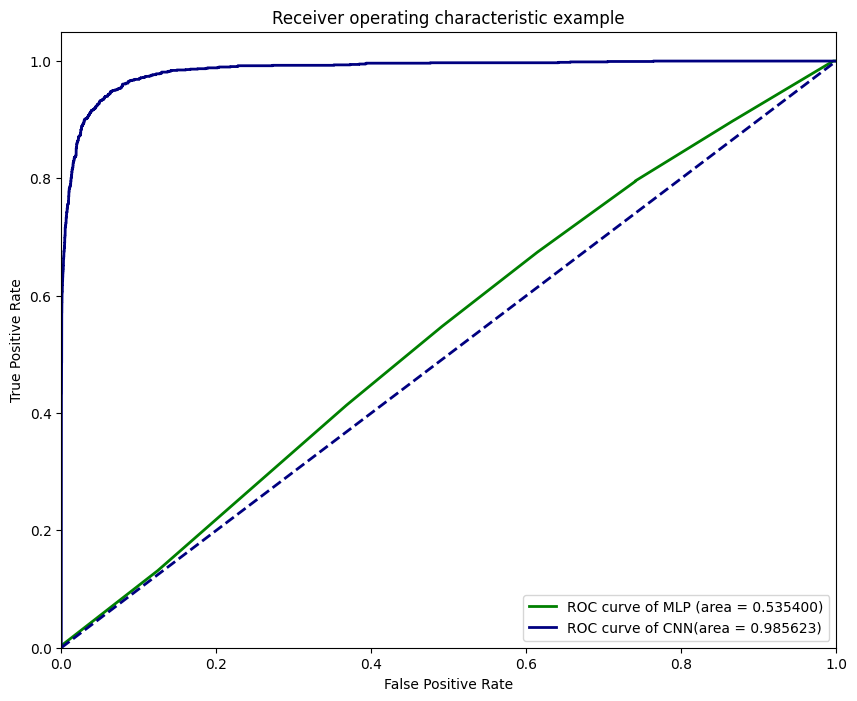

In [78]:
plt.figure(figsize=(10,8))
lw = 2

# MLP
plt.plot(fpr_mlp, tpr_mlp, color='green',
         lw=lw, label='ROC curve of MLP (area = %0.6f)' % roc_auc_mlp)

# CNN 1
plt.plot(fpr_cnn, tpr_cnn, color='navy',
         lw=lw, label='ROC curve of CNN(area = %0.6f)' % roc_auc_cnn)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

The CNN Model performs much better compared to a standard MLP. The CNN ROC Curve is near ideal with a area of 0.985, while the MLP ROC Curve is only slightly above the random guessing line at 0.535, which means that for the MLP model, it is only barely better than just randomly guessing.  

# Exceptional Work

We will be creating one more CNN, this time with 64 Filters and a Kernal of 4, and comparing to the MLP

Fifth Convolutional Network - 64 Filters and Kernal of 4

In [47]:
cnn5 = Sequential()


cnn5.add(Conv2D(filters=64,
                input_shape = (img_wh,img_wh,1),
                kernel_size=(4,4),
                padding='same',
                activation='relu', data_format="channels_last"))\


cnn5.add(Conv2D(filters=64,
                kernel_size=(4,4),
                padding='same',
                activation='relu'))
cnn5.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))


# add one layer on flattened output
cnn5.add( Flatten() )
cnn5.add( Dense(100) )
cnn5.add( Activation('relu') )
cnn5.add( Dense(NUM_CLASSES) )
cnn5.add( Activation('softmax') )

# Let's train the model
cnn5.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

history5 = cnn5.fit(datagen.flow(X_train, y_train_ohe, batch_size=64),
                   steps_per_epoch=int(len(X_train)/64), # how many generators to go through per epoch
                   epochs=30, verbose=1,
                   validation_data=(X_test,y_test_ohe))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


86/86 ━━━━━━━━━━━━━━━━━━━━ 39s 221ms/step - accuracy: 0.2552 - loss: 620.0623 - val_accuracy: 0.5594 - val_loss: 1.2745
Epoch 2/30
 1/86 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.5156 - loss: 1.2365

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5156 - loss: 1.2365 - val_accuracy: 0.6036 - val_loss: 1.3234
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.4071 - loss: 3.3626 - val_accuracy: 0.5319 - val_loss: 1.8784
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3906 - loss: 2.2099 - val_accuracy: 0.5899 - val_loss: 1.3818
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - accuracy: 0.5281 - loss: 12.0424 - val_accuracy: 0.5464 - val_loss: 1.5341
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5000 - loss: 1.3131 - val_accuracy: 0.5268 - val_loss: 1.5110
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.5537 - loss: 1.3483 - val_accuracy: 0.7065 - val_loss: 1.3015
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6562 - loss: 1.0324 - val_accuracy: 0.6884 - val_loss: 1.0566
Epoch 9/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.5042 - loss: 12.1386 - val_accuracy: 0.6645 - val_lo

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


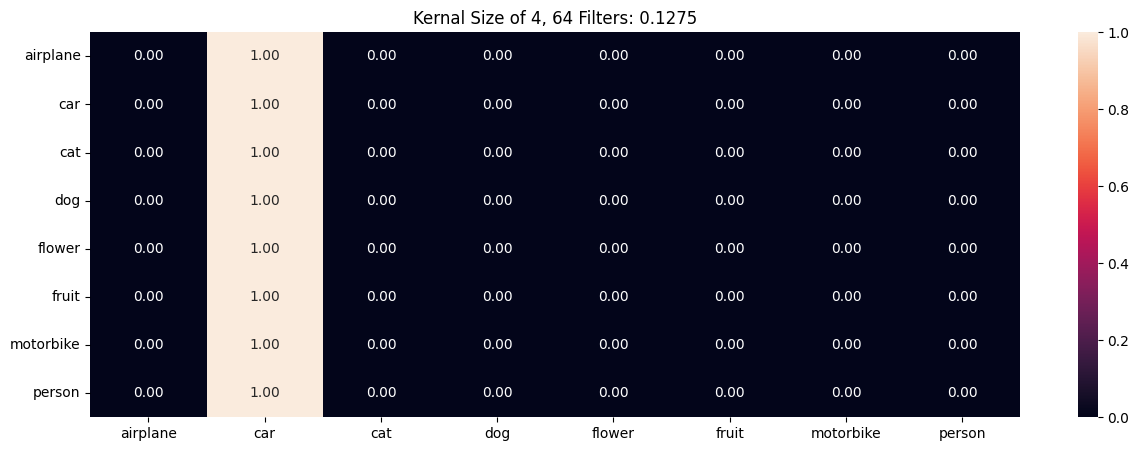

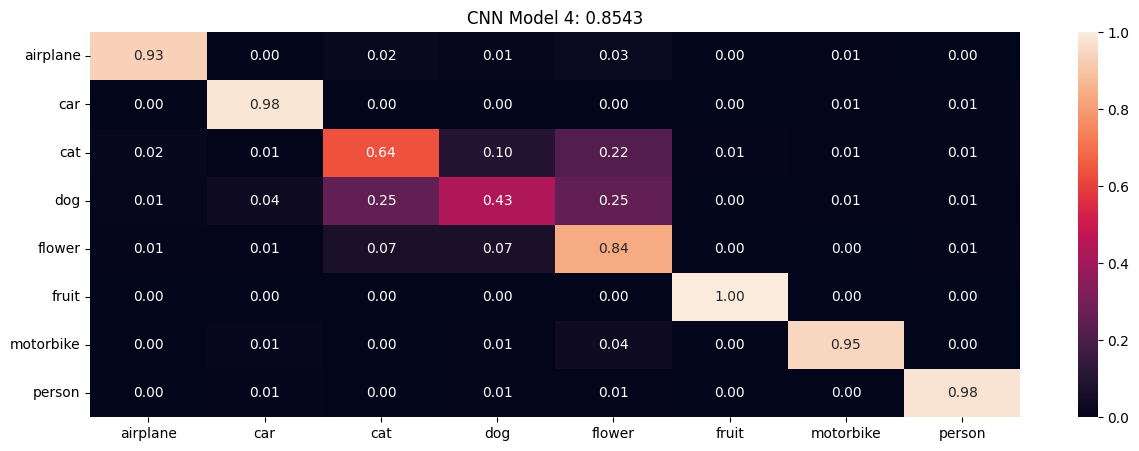

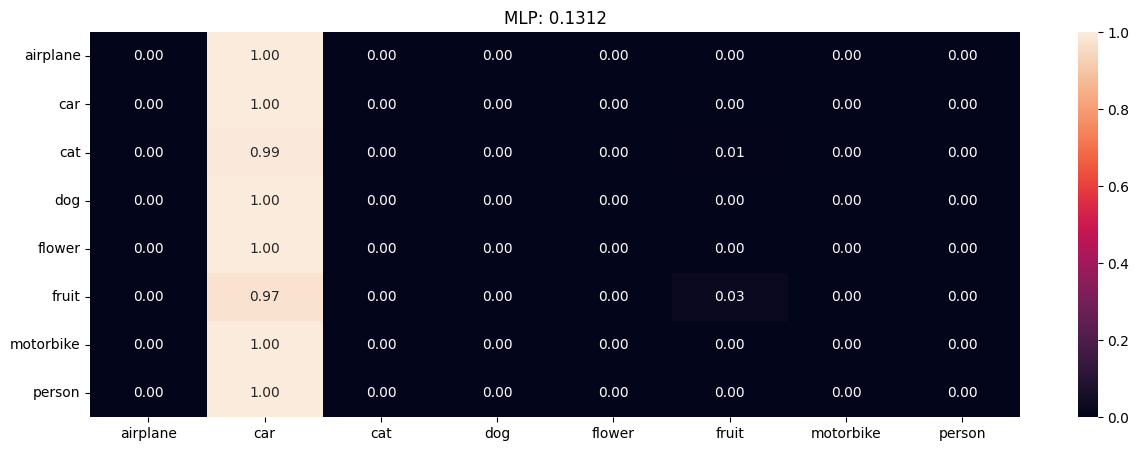

In [74]:
summarize_net(cnn5, X_test, y_test, title_text='Kernal Size of 4, 64 Filters: ')
summarize_net(cnn4, X_test, y_test, title_text='CNN Model 4: ')
summarize_net(mlp, X_test, y_test, title_text='MLP: ')

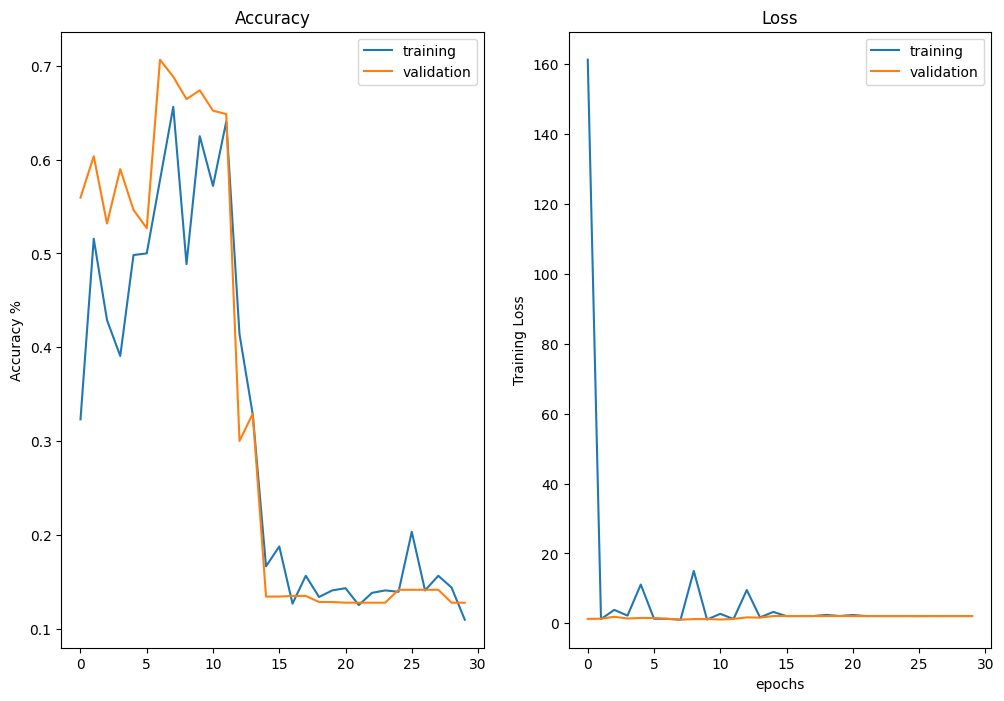

In [58]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(history5.history['accuracy'], label='training')

plt.ylabel('Accuracy %')
plt.title('Training')
plt.plot(history5.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history5.history['loss'], label='training')
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.plot(history5.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.title('Loss')
plt.legend()
plt.show()

In [50]:
model5 = KerasClassifier(model=cnn5, epochs=30, batch_size=10, verbose=1)
my_scorer5 = make_scorer(accuracy_score)
results5 = cross_val_score(model5, X_test, y_test_ohe, cv=sss, scoring=my_scorer5)
print(results5.mean())

Epoch 1/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.1280 - loss: 2.0720
Epoch 2/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.1366 - loss: 2.0780
Epoch 3/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.1363 - loss: 2.0723
Epoch 4/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.1458 - loss: 2.0689
Epoch 5/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.1420 - loss: 2.0713
Epoch 6/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.1521 - loss: 2.0686
Epoch 7/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.1373 - loss: 2.0710
Epoch 8/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.1308 - loss: 2.0731
Epoch 9/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.1355 - loss: 2.0670
Epoch 10/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.1322 - loss: 2.0703
Epoch 11/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.1455 - loss: 2.0733
Epoch 12/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 

In [51]:
acc5, fpr_cnn5, tpr_cnn5, roc_auc_cnn5 = network_predict(cnn5, X_test, y_test_ohe)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


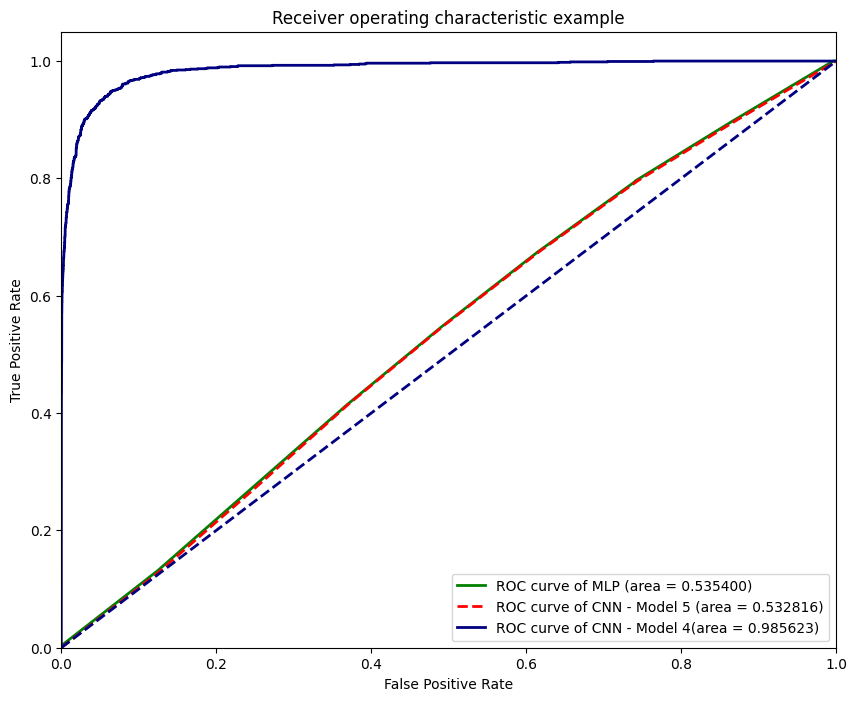

In [83]:
plt.figure(figsize=(10,8))
lw = 2

# MLP
plt.plot(fpr_mlp, tpr_mlp, color='green',
         lw=lw, label='ROC curve of MLP (area = %0.6f)' % roc_auc_mlp)

# CNN 1
plt.plot(fpr_cnn5, tpr_cnn5, color='red', linestyle='--',
         lw=lw, label='ROC curve of CNN - Model 5 (area = %0.6f)' % roc_auc_cnn5)

# CNN 1
plt.plot(fpr_cnn, tpr_cnn, color='navy',
         lw=lw, label='ROC curve of CNN - Model 4(area = %0.6f)' % roc_auc_cnn)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

It is interesting that 64 Filters and a Kernal size of 4 caused the Convolutional Network to perform roughly equal to the standard MLP. The ROC Curve of MLP is 0.535, and ROC Curve of Model 5 is 0.532, which is extremely similar. In comparison, ROC Curve of Model 4 has a area of 0.98, which is much greater. This means that when it comes to creating Convolutional Networks, it is best to focus on either 32 or 16 filters.

In conclusion, the best parameters to use are either 32 or 16 filters, and a kernal size of 3 when creating a convolutional network for our dataset

# References

1. https://github.com/eclarson/MachineLearningNotebooks/blob/master/11.%20Convolutional%20Neural%20Networks.ipynb

2. https://github.com/eclarson/MachineLearningNotebooks/blob/master/12.%20More%20Advanced%20CNN%20Techniques.ipynb

3. https://github.com/eclarson/MachineLearningNotebooks/blob/master/12a.%20More%20Advanced%20CNN%20Techniques%20as%20TFData.ipynb